# Introduction

We're trying to understand how the spikes (and genes) behave on our single cell datasets

# Index

* Spike Scatter plots
* <a href="#Hs_purkinje-spike-scatter">Hs_purkinje spike scatter</a>
* <a href="#Hs_asp_purkinje_UMB5294-spike-scatter">Hs_asp_purkinje_UMB5294 spike scatter</a>
* <a href="#Mm_purkinje-spike-scatter">Mm_purkinje spike scatter</a>
* <a href="#Mm_pyramidal-spike-scatter">Mm_pyramidal spike scatter</a>

* <a href="#Genes-Detected">Genes Detected</a>
* <a href="#Hs_purkinje_poolsplit-Covariance">Hs_purkine_poolsplit Covariance</a>
* <a href="#Hs_purkinje_poolsplit-shuffled-Covariance">Hs_purkine_poolsplit Shuffled Covariance</a>
* <a href="#Hs_purkinje_poolsplit-shuffled-Genes-Detected">Hs_purkine_poolsplit Shuffled Genes Detected</a>

In [2]:
import pandas
import numpy
import os
import sys
import collections

import bokeh
from bokeh import mpl
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.io import output_notebook
import bokeh.io
import bokeh.resources
import bokeh.charts
from bokeh.models import HoverTool
from bokeh.palettes import *


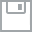
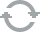
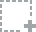
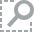
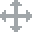
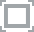
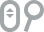
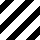
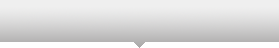
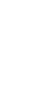
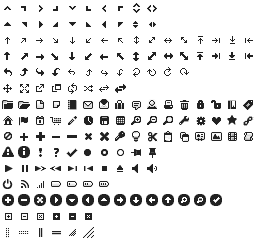
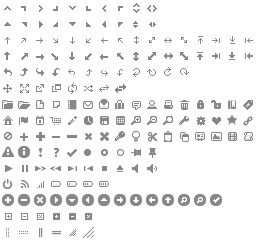
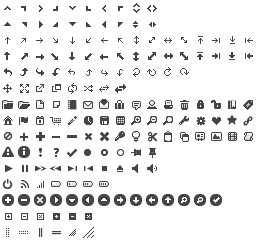
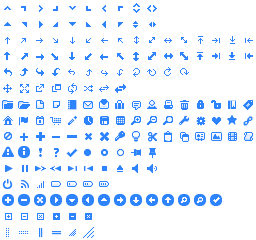
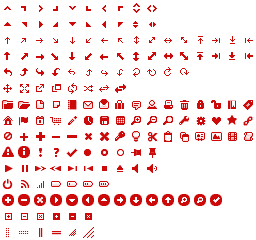
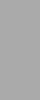
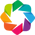
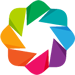

In [3]:
output_notebook()

In [4]:
LONG_RNA_SEQ = os.path.expanduser('~diane/proj/long-rna-seq-condor')
if LONG_RNA_SEQ not in sys.path:
    sys.path.append(LONG_RNA_SEQ)
from models import get_single_spike_cpc
from madqc import compute_all_vs_all_scores

In [5]:
def create_figure(xname, yname, extra_title='', **kwargs):
    hover = HoverTool(
        tooltips = [
            (xname, '@'+xname),
            (yname, '@'+yname),
            ('gene_id', '@gene_id'),
            ('library_id', '@library_id'),
            ('name', '@experiment_name'),
            # description is too long for my tooltip box
            #('description', '@description'),
            #('organism', '@organism'),
            #('biosample', '@biosample'),
            #('source', '@biosample_lab'),
            #('starting', '@starting'),
            #('age', '@age'),
            #('lab', '@lab'),
            #('rfa', '@rfa'),
        ]
    )    

    p = figure(
        title = "{} vs {} {}".format(xname, yname, extra_title),
        tools=['box_zoom', 'wheel_zoom', 'pan', hover, 'save', 'reset'],
        **kwargs
    )
    p.xaxis.axis_label = xname
    p.yaxis.axis_label = yname
    
    return p

def setdefault_style(**kwargs):
    extra = kwargs.copy()
    extra.setdefault('fill_alpha', 0.4)
    extra.setdefault('size', 7)
    extra.setdefault('line_color', 'black')
    extra.setdefault('line_alpha', 0.4)
    return extra



In [6]:
rsems = pandas.HDFStore('rsem-genes.h5', 'r')

In [7]:
library_to_name = {}
experiment_names = {}
for i, row in rsems['metadata'].iterrows():
    library_to_name[str(row.library_id)] = row.experiment_name
    experiment_names.setdefault(row.experiment_name, []).append(row.library_id)

In [8]:
for k in sorted(experiment_names.keys()):
    print(k, ','.join(experiment_names[k]))

Hs_asp_purkinje_UMB5294_poolsplit 13843,13844,13845,13846,13847,13848,13849,13850,13851,13852,13853,13854,13855,13856,13857,13858,13859,13860
Hs_asp_purkinje_UMB5294_single 13824,13825,13826,13827,13828,13829,13830,13831,13832,13833,13834,13835,13836,13837,13838,13839,13840,13841,13842
Hs_purkinje_poolsplit 13645,13646,13647,13648,13649,13650,13651,13652,13653,13654,13655,13656,13657,13658,13659,13660,13661,13662,13663,13664
Hs_purkinje_single 13625,13626,13627,13628,13629,13630,13631,13632,13633,13634,13635,13636,13637,13638,13639,13640,13641,13642,13643,13644
Mm_layer_V_pyramidal_poolsplit 15304,15305,15306,15307,15308,15309,15310,15311,15356,15357,15358,15359,15360,15361,15362
Mm_layer_V_pyramidal_single 15272,15273,15275,15276,15277,15278,15279,15280,15281,15282,15283,15284,15285,15286,15287,15352,15353,15354
Mm_purkinje_poolsplit 15288,15289,15290,15291,15292,15293,15294,15295,15296,15297,15298,15299,15300,15301,15302,15303
Mm_purkinje_single 15256,15257,15258,15259,15260,15261,15

In [9]:
name_to_color = {
    'Hs_asp_purkinje_UMB5294_poolsplit': Purples3[0],
    'Hs_asp_purkinje_UMB5294_single': Purples3[1],
    
    'Hs_purkinje_single': Oranges3[0],
    'Hs_purkinje_poolsplit': Oranges3[1],
    
    'Mm_purkinje_single': Blues3[0],
    'Mm_purkinje_poolsplit': Blues3[1],
    
    'Mm_layer_V_pyramidal_single': Greens3[0],
    'Mm_layer_V_pyramidal_poolsplit': Greens3[1],
}

def make_linked_axes():
    hs_purkinje_x = bokeh.models.DataRange1d()
    hs_asp_purkinje_x = bokeh.models.DataRange1d()
    mm_purkinje_x = bokeh.models.DataRange1d()
    mm_pyramidal_x = bokeh.models.DataRange1d()

    hs_purkinje_y = bokeh.models.DataRange1d()
    hs_asp_purkinje_y = bokeh.models.DataRange1d()
    mm_purkinje_y = bokeh.models.DataRange1d()
    mm_pyramidal_y = bokeh.models.DataRange1d()

    name = {}
    name['y'] = {
        'Hs_asp_purkinje_UMB5294_poolsplit': hs_asp_purkinje_y,
        'Hs_asp_purkinje_UMB5294_single': hs_asp_purkinje_y,
    
        'Hs_purkinje_single': hs_purkinje_y,
        'Hs_purkinje_poolsplit': hs_purkinje_y,
    
        'Mm_purkinje_single': mm_purkinje_y,
        'Mm_purkinje_poolsplit': mm_purkinje_y,
    
        'Mm_layer_V_pyramidal_single': mm_pyramidal_y,
        'Mm_layer_V_pyramidal_poolsplit': mm_pyramidal_y,
    }

    name['x'] = {
        'Hs_asp_purkinje_UMB5294_poolsplit': hs_asp_purkinje_x,
        'Hs_asp_purkinje_UMB5294_single': hs_asp_purkinje_x,
    
        'Hs_purkinje_single': hs_purkinje_x,
        'Hs_purkinje_poolsplit': hs_purkinje_x,
    
        'Mm_purkinje_single': mm_purkinje_x,
        'Mm_purkinje_poolsplit': mm_purkinje_x,
    
        'Mm_layer_V_pyramidal_single': mm_pyramidal_x,
        'Mm_layer_V_pyramidal_poolsplit': mm_pyramidal_x,
    }
    return name

In [10]:
spike_cpcs = dict(get_single_spike_cpc())

def make_spike_colors(cpcs):
    colors = [
        Blues3[0],
        Greens3[0],
        Reds3[0],
        Purples3[0],
        Greys3[0],
        BrBG3[2],
        Greys4[3],
    ]
    spike_color_map = {}
    cpc_counter = collections.Counter()
    
    for name, cpc in cpcs.items():
        spike_color_map[name] = colors[cpc_counter[cpc]]
        cpc_counter[cpc] += 1
    
    return spike_color_map

spike_color_map = make_spike_colors(spike_cpcs)

In [11]:
def jitter_spike(name):
    cpc = spike_cpcs.get(name, None)
    if cpc:
        spread = min((0.1 * cpc), 100)
        cpc = cpc + (spread * (numpy.random.random() - 0.5))
        return cpc
    return numpy.nan

In [12]:
#pool_fpkm = create_figure('spike_cpc', 'FPKM', 'Pool Split')
#single_fpkm = create_figure('spike_cpc', 'FPKM', 'Single')

name_axes = make_linked_axes()
plots  = {name: create_figure('spike_cpc', 'FPKM', name, 
                              y_range=name_axes['y'][name],
                              x_range=name_axes['x'][name],
                             ) for name in name_to_color }
extra = setdefault_style(fill_alpha=0.6)
missing_spike_data = collections.Counter()

for key in [ x for x in rsems.keys() if x.startswith('/genes/')]:
    library_id = key[-5:]
    experiment_name = library_to_name[library_id]
    rsem = rsems[key]
    spike_filter = rsem['gene_id'].map(lambda x: x.startswith('gSpikein'))

    rsem['library_id'] = library_id
    rsem['experiment_name'] = experiment_name
    rsem['spike_cpc'] = rsem[spike_filter]['gene_id'].map(jitter_spike)
    rsem['spike_color'] = rsem[spike_filter]['gene_id'].map(lambda x: spike_color_map.get(x))
    
    for spike_name in rsem[spike_filter]['gene_id']:
        if spike_name not in spike_color_map:
            missing_spike_data[spike_name] += 1
        
    plots[experiment_name].circle(
        'spike_cpc', 'FPKM', 
        source=ColumnDataSource(rsem[spike_filter]),
        color=rsem[spike_filter]['spike_color'],            
        #legend=name,
        **extra)

missing_spike_data

Counter({'gSpikein_ERCC-00018': 142, 'gSpikein_ERCC-00128': 142, 'gSpikein_ERCC-00007': 142, 'gSpikein_ERCC-00023': 142})

In [13]:
def show_and_save_pairs(plots, left, right, title):
    p = bokeh.io.hplot(plots[left], plots[right])
    filename = os.path.join('/dev/shm/{}.html'.format(title.lower().replace(' ', '_')))
    resources = bokeh.resources.Resources(
        mode='server',
        root_url='/~diane/bokeh/0.10.0/'
    )
    bokeh.io.save(obj=p, filename=filename, resources=resources, title=title)
    show(p)

# Hs_purkinje spike scatter

<a href="#Index">Back to index</a>

In [14]:
show_and_save_pairs(plots, 'Hs_purkinje_poolsplit', 'Hs_purkinje_single', 'HS_purkinje cpt vs FPKM')

# Hs_asp_purkinje_UMB5294 spike scatter

<a href="#Index">Back to index</a>

In [15]:
show_and_save_pairs(plots, 'Hs_asp_purkinje_UMB5294_poolsplit', 'Hs_asp_purkinje_UMB5294_single', 'HS_asp_purkinje_UMB5294 cpt vs FPKM')

#Mm_purkinje spike scatter

<a href="#Index">Back to index</a>

In [16]:
show_and_save_pairs(plots, 'Mm_purkinje_poolsplit', 'Mm_purkinje_single', 'Mm_purkinje cpt vs FPKM')

#Mm_pyramidal spike scatter

<a href="#Index">Back to index</a>

In [17]:
show_and_save_pairs(plots, 'Mm_layer_V_pyramidal_poolsplit', 'Mm_layer_V_pyramidal_single', 'Mm_pyramidal cpt vs FPKM')

#Genes Detected

In [44]:
def genes_detected_histogram(experiment_name, threshold=0):
    filename = experiment_name + '_FPKM.h5'
    store = pandas.HDFStore(filename, 'r')
    q = store['/quantifications']
    genes_detected = q[q > 0].count(axis=1)
    genes_detected.name = 'Genes Detected'
    return bokeh.charts.Histogram(genes_detected, title=experiment_name)

In [45]:
show(genes_detected_histogram('Hs_purkinje_poolsplit'))

In [46]:
show(genes_detected_histogram('Hs_purkinje_single'))

In [47]:
show(genes_detected_histogram('Mm_layer_V_pyramidal_poolsplit'))
show(genes_detected_histogram('Mm_layer_V_pyramidal_single'))

In [48]:
show(genes_detected_histogram('Mm_purkinje_poolsplit'))
show(genes_detected_histogram('Mm_purkinje_single'))

#Hs_purkinje_poolsplit Covariance

<a href="#Index">Back to index</a>

In [49]:
store = pandas.HDFStore('Hs_purkinje_poolsplit_FPKM.h5', 'r')
q = store['/quantifications']
store.close()

Compute covariance of good data

In [50]:
q.cov()

13645         13646         13647         13648         13649  \
13645  54592.017917  60896.788047  55670.680715  51849.869330  55283.802642   
13646  60896.788047  68605.095655  62410.068441  58059.432175  61796.794864   
13647  55670.680715  62410.068441  57419.229252  53234.760063  56445.219878   
13648  51849.869330  58059.432175  53234.760063  50113.032733  52966.335491   
13649  55283.802642  61796.794864  56445.219878  52966.335491  57373.453999   
13650  55109.557565  61624.024835  56404.302950  52772.451292  56342.343146   
13651  55528.154426  62183.287207  57077.403372  53525.505954  56779.707442   
13652  51953.000504  58163.510672  53156.111164  49596.687906  53130.834938   
13653  59992.981652  67227.441827  61525.560784  57663.623365  61415.339856   
13654  56009.737842  62763.596471  57458.148254  54062.097551  57695.860171   
13655  59517.216922  66755.069859  61036.211538  57543.867748  61477.378327   
13656  54562.463596  61097.795110  55905.218581  52301.586885  55700.285193   
13657  58542.462882  65544.474304  59955.830936  56149.131868  59880.220197   
13658  51475.429507  57511.931721  52713.075582  49489.083525  52983.553625   
13659  61575.265364  68994.283674  63099.696247  59323.313774  63134.420820   
13660  57816.337431  64807.434883  59212.449362  55566.810261  59347.904408   
13661  62800.503012  70484.413908  64532.680681  60678.226502  64513.087026   
13662  60392.437258  67707.533498  62027.009411  58319.401967  61903.195789   
13663  52912.524373  59282.154699  54507.113228  50836.411234  53542.093335   
13664  55585.135283  62160.295368  56760.743749  52961.499913  56973.780987   

              13650         13651         13652         13653         13654  \
13645  55109.557565  55528.154426  51953.000504  59992.981652  56009.737842   
13646  61624.024835  62183.287207  58163.510672  67227.441827  62763.596471   
13647  56404.302950  57077.403372  53156.111164  61525.560784  57458.148254   
13648  52772.451292  53525.505954  49596.687906  57663.623365  54062.097551   
13649  56342.343146  56779.707442  53130.834938  61415.339856  57695.860171   
13650  56512.725654  56585.681166  52577.654066  61319.417643  57364.873152   
13651  56585.681166  58425.620395  53119.607344  62274.925688  58461.151247   
13652  52577.654066  53119.607344  50140.878856  57225.692293  53574.905835   
13653  61319.417643  62274.925688  57225.692293  67876.494355  63241.521385   
13654  57364.873152  58461.151247  53574.905835  63241.521385  59999.009472   
13655  60962.681142  62482.105127  56962.208279  67506.158131  63793.421452   
13656  55422.659852  56138.215102  52188.468687  60665.733928  56738.303854   
13657  59630.910057  60599.971145  55891.055512  65388.617765  61399.960790   
13658  52466.992254  53131.432687  49378.959890  57275.682536  53832.773460   
13659  63042.790181  64251.195833  58654.554642  69573.506341  65361.911262   
13660  59054.411512  59954.453451  55260.933899  64935.381287  60976.184343   
13661  64323.199434  66157.772976  59901.519594  71342.316291  67171.990724   
13662  61856.616848  63175.461926  57567.093483  68304.406473  64226.500189   
13663  53639.981752  54775.776166  50432.013542  58729.541752  54879.115925   
13664  56438.515435  56664.326203  53245.137195  61394.291475  57445.958058   

              13655         13656         13657         13658         13659  \
13645  59517.216922  54562.463596  58542.462882  51475.429507  61575.265364   
13646  66755.069859  61097.795110  65544.474304  57511.931721  68994.283674   
13647  61036.211538  55905.218581  59955.830936  52713.075582  63099.696247   
13648  57543.867748  52301.586885  56149.131868  49489.083525  59323.313774   
13649  61477.378327  55700.285193  59880.220197  52983.553625  63134.420820   
13650  60962.681142  55422.659852  59630.910057  52466.992254  63042.790181   
13651  62482.105127  56138.215102  60599.971145  53131.432687  64251.195833   
13652  56962.208279  52188.468687  55891.055512  49378.959890 

#Hs_purkinje_poolsplit shuffled Covariance

<a href="#Index">Back to index</a>

Make bad data by shuffling values in two libraries

In [51]:
qbad = q.copy()

In [52]:
qbad['13648'] = numpy.random.permutation(qbad['13648'])
qbad['13652'] = numpy.random.permutation(qbad['13652'])

In [53]:
qbad.cov()

13645         13646         13647         13648         13649  \
13645  54592.017917  60896.788047  55670.680715     44.654253  55283.802642   
13646  60896.788047  68605.095655  62410.068441     50.590965  61796.794864   
13647  55670.680715  62410.068441  57419.229252     19.425043  56445.219878   
13648     44.654253     50.590965     19.425043  50113.032733     60.493216   
13649  55283.802642  61796.794864  56445.219878     60.493216  57373.453999   
13650  55109.557565  61624.024835  56404.302950     64.112267  56342.343146   
13651  55528.154426  62183.287207  57077.403372     63.211021  56779.707442   
13652    -67.536735    -78.523279    -71.377065    -93.788796    -70.151942   
13653  59992.981652  67227.441827  61525.560784     30.092472  61415.339856   
13654  56009.737842  62763.596471  57458.148254     65.298710  57695.860171   
13655  59517.216922  66755.069859  61036.211538     53.448034  61477.378327   
13656  54562.463596  61097.795110  55905.218581     46.901917  55700.285193   
13657  58542.462882  65544.474304  59955.830936     27.052794  59880.220197   
13658  51475.429507  57511.931721  52713.075582      7.566874  52983.553625   
13659  61575.265364  68994.283674  63099.696247     59.469991  63134.420820   
13660  57816.337431  64807.434883  59212.449362     51.097381  59347.904408   
13661  62800.503012  70484.413908  64532.680681     30.376637  64513.087026   
13662  60392.437258  67707.533498  62027.009411     24.923191  61903.195789   
13663  52912.524373  59282.154699  54507.113228     33.944387  53542.093335   
13664  55585.135283  62160.295368  56760.743749     49.026562  56973.780987   

              13650         13651         13652         13653         13654  \
13645  55109.557565  55528.154426    -67.536735  59992.981652  56009.737842   
13646  61624.024835  62183.287207    -78.523279  67227.441827  62763.596471   
13647  56404.302950  57077.403372    -71.377065  61525.560784  57458.148254   
13648     64.112267     63.211021    -93.788796     30.092472     65.298710   
13649  56342.343146  56779.707442    -70.151942  61415.339856  57695.860171   
13650  56512.725654  56585.681166    -73.309208  61319.417643  57364.873152   
13651  56585.681166  58425.620395    -66.138382  62274.925688  58461.151247   
13652    -73.309208    -66.138382  50140.878856    -58.009263    -71.889597   
13653  61319.417643  62274.925688    -58.009263  67876.494355  63241.521385   
13654  57364.873152  58461.151247    -71.889597  63241.521385  59999.009472   
13655  60962.681142  62482.105127    -85.636386  67506.158131  63793.421452   
13656  55422.659852  56138.215102    -72.931204  60665.733928  56738.303854   
13657  59630.910057  60599.971145    -69.669214  65388.617765  61399.960790   
13658  52466.992254  53131.432687    -62.829519  57275.682536  53832.773460   
13659  63042.790181  64251.195833    -49.791818  69573.506341  65361.911262   
13660  59054.411512  59954.453451    -75.242281  64935.381287  60976.184343   
13661  64323.199434  66157.772976    -73.289706  71342.316291  67171.990724   
13662  61856.616848  63175.461926    -68.103696  68304.406473  64226.500189   
13663  53639.981752  54775.776166    -54.778461  58729.541752  54879.115925   
13664  56438.515435  56664.326203    -70.053453  61394.291475  57445.958058   

              13655         13656         13657         13658         13659  \
13645  59517.216922  54562.463596  58542.462882  51475.429507  61575.265364   
13646  66755.069859  61097.795110  65544.474304  57511.931721  68994.283674   
13647  61036.211538  55905.218581  59955.830936  52713.075582  63099.696247   
13648     53.448034     46.901917     27.052794      7.566874     59.469991   
13649  61477.378327  55700.285193  59880.220197  52983.553625  63134.420820   
13650  60962.681142  55422.659852  59630.910057  52466.992254  63042.790181   
13651  62482.105127  56138.215102  60599.971145  53131.432687  64251.195833   
13652    -85.636386    -72.931204    -69.669214    -62.829519 

#Hs_purkinje_poolsplit shuffled Genes Detected

<a href="#Index">Back to index</a>

With the shuffled data how does the Gene Detetected metric work?

In [54]:
genes_detected = qbad[qbad > 0].count(axis=1)
genes_detected.name = 'Genes Detected'
show(bokeh.charts.Histogram(genes_detected))

In [55]:
spikes_detected = genes_detected[genes_detected.index.map(lambda x: x.startswith('gSpikein'))]

In [56]:
spikes_detected[spikes_detected > 18]

gene_id
gSpikein_ERCC-00004    19
gSpikein_ERCC-00022    19
gSpikein_ERCC-00043    19
gSpikein_ERCC-00046    19
gSpikein_ERCC-00076    19
gSpikein_ERCC-00092    19
gSpikein_ERCC-00096    19
gSpikein_ERCC-00130    19
gSpikein_ERCC-00136    19
Name: Genes Detected, dtype: int64

In [57]:
spike_concentration = get_single_spike_cpc()

In [58]:
names = []
for name in spikes_detected[spikes_detected  >= 18].index:
    names.append((name, spikes_detected[name], spike_concentration[name]))
sorted_names = sorted(names, key=lambda x: x[2])
print(len(sorted_names))
for n in sorted_names:
    print('{} {} {:>8.2f}'.format(*n))

20
gSpikein_ERCC-00131 18    14.11
gSpikein_ERCC-00022 19    28.22
gSpikein_ERCC-00060 18    28.22
gSpikein_ERCC-00076 19    28.22
gSpikein_ERCC-00092 19    28.22
gSpikein_ERCC-00042 18    56.44
gSpikein_ERCC-00043 19    56.44
gSpikein_ERCC-00111 18    56.44
gSpikein_ERCC-00003 18   112.88
gSpikein_ERCC-00009 18   112.88
gSpikein_ERCC-00108 18   112.88
gSpikein_ERCC-00145 18   112.88
gSpikein_ERCC-00136 19   225.75
gSpikein_ERCC-00046 19   451.50
gSpikein_ERCC-00113 18   451.50
gSpikein_ERCC-00004 19   903.00
gSpikein_ERCC-00002 18  1806.00
gSpikein_ERCC-00074 18  1806.00
gSpikein_ERCC-00096 19  1806.00
gSpikein_ERCC-00130 19  3612.00


In [59]:
len(spike_concentration[spike_concentration > 10])

26

In [60]:
q[q.index == 'gSpikein_ERCC-00116']

13645  13646  13647  13648  13649  13650  13651  13652  \
gene_id                                                                       
gSpikein_ERCC-00116   5.08   4.69   0.12   7.13  15.59   0.32      0  13.14   

                     13653  13654  13655  13656  13657  13658  13659  13660  \
gene_id                                                                       
gSpikein_ERCC-00116   6.17      0   8.02    5.3      0  10.89  15.77      0   

                     13661  13662  13663  13664  
gene_id                                          
gSpikein_ERCC-00116  12.16  15.23    5.2      0

In [61]:
q[q.index.map(lambda x: x in (spike_concentration > 1000).index)]

13645   13646   13647    13648    13649    13650  \
gene_id                                                                  
gSpikein_ERCC-00002  895.12  853.62  917.74  1251.12  1566.51  1347.99   
gSpikein_ERCC-00003   28.15   70.10   60.51    98.80    90.54   165.73   
gSpikein_ERCC-00004  421.71  381.82  356.88   574.31   803.20   537.84   
gSpikein_ERCC-00009   88.86   40.02   73.94   146.65    91.50    59.30   
gSpikein_ERCC-00012    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00013    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00014    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00016    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00017    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00019    0.00    0.00    4.21     0.00    18.50     1.96   
gSpikein_ERCC-00022   12.68    8.21   14.16    39.95    32.38     6.94   
gSpikein_ERCC-00024    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00025    3.64    3.45    0.00     3.91     1.20     5.96   
gSpikein_ERCC-00028    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00031    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00033    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00034    5.75    0.00    5.82     0.00     0.00     0.03   
gSpikein_ERCC-00035    0.00    3.06    0.63    12.00     1.43     0.56   
gSpikein_ERCC-00039    4.03    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00040    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00041    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00042   28.92   18.75   40.33    70.64    49.17    54.86   
gSpikein_ERCC-00043   45.62   26.77   50.10    16.35    78.19    47.99   
gSpikein_ERCC-00044    5.17   14.47    4.37     5.61     5.65     6.62   
gSpikein_ERCC-00046  294.85  175.44  255.72   425.74   500.90   395.17   
gSpikein_ERCC-00048    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00051    0.00    0.00    0.00     1.07     9.71     1.78   
gSpikein_ERCC-00053    0.00    2.71    0.00     4.27     0.00     0.62   
gSpikein_ERCC-00054    0.00    0.00    0.00     0.00     2.16     0.00   
gSpikein_ERCC-00057    0.00    0.00    0.00     0.00     0.00     0.00   
...                     ...     ...     ...      ...      ...      ...   
gSpikein_ERCC-00116    5.08    4.69    0.12     7.13    15.59     0.32   
gSpikein_ERCC-00117    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00120    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00123    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00126    5.31    0.00    0.00     0.00     0.00     7.51   
gSpikein_ERCC-00130  939.22  831.83  894.32  1250.54  1379.52  1342.53   
gSpikein_ERCC-00131   20.17    9.98    6.91    11.22     8.37    16.92   
gSpikein_ERCC-00134    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00136  112.57   74.66   93.30   142.35   205.18   164.48   
gSpikein_ERCC-00137    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00138    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00142    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00143    0.00    0.00    0.00     8.07     0.06     0.00   
gSpikein_ERCC-00144    0.00    2.05    0.00     4.22     0.09     3.73   
gSpikein_ERCC-00145   17.51   27.88   35.30    22.99    55.31    33.50   
gSpikein_ERCC-00147    0.00    0.00    0.00     0.00     0.00     1.52   
gSpikein_ERCC-00148    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00150    0.00    0.00    0.18     0.00     0.00     0.00   
gSpikein_ERCC-00154    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00156    0.00    0.00    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00157    0.00    3.98    0.00     0.00     0.00     0.00   
gSpikein_ERCC-00158    0.0

In [62]:
tpms = { k[-5:]: rsems[k][['gene_id', 'TPM']].set_index('gene_id') for k in list(rsems.keys()) if k.startswith('/genes') }

In [63]:
for k in tpms:
    tpms[k].columns = [k]

In [66]:
fulltable = pandas.concat(list(tpms.values()), axis=1)

In [67]:
tpmspikes = fulltable[fulltable.index.map(lambda x: x.startswith('gSpikein'))]

In [68]:
spikesfrac = tpmspikes.sum(axis=0) / fulltable.sum(axis=0)

In [69]:
spikesfrac[spikesfrac > .05]

13633    0.119541
13852    0.053719
13839    0.082819
13849    0.064380
13850    0.136319
13830    0.061038
13853    0.059240
13854    0.063183
13835    0.080269
13845    0.054122
dtype: float64

In [70]:
spikesfrac['15283']

0.03584150860196203

In [71]:
fpkms = { k[-5:]: rsems[k][['gene_id', 'FPKM']].set_index('gene_id') for k in list(rsems.keys()) if k.startswith('/genes') }

In [72]:
for k in fpkms:
    fpkms[k].columns = [k]
fullfpkms = pandas.concat(list(fpkms.values()), axis=1)

In [73]:
fpkmspikes = fullfpkms[fullfpkms.index.map(lambda x: x.startswith('gSpikein'))]

In [74]:
fpkmspikemean = fpkmspikes[fpkmspikes > 0].dropna(how='any').mean(axis=0)

In [75]:
fpkmspikemean[fpkmspikemean > 1000]

13655    1172.741333
13842    1102.703333
13633    6112.889333
13662    1033.822000
13857    2191.922667
13635    1332.896000
13852    3219.029333
13636    1474.187333
13858    2103.948667
13833    2040.344667
13839    4141.052000
13849    3679.216000
13850    8812.128000
13834    1280.256000
13661    1237.350667
13824    1523.095333
13830    3273.722667
13841    1179.164000
13853    3494.657333
13854    3568.868667
13848    1664.484000
13843    1423.693333
13836    1228.704667
13846    1415.219333
13855    2138.768000
15283    2202.813333
13860    2104.002000
13629    1435.518667
13832    1317.382667
13835    3894.807333
13856    1839.377333
13838    2104.490667
13859    1413.497333
13831    1338.320000
13845    3337.502000
13626    1158.324667
13637    1048.988000
13840    1730.453333
13844    1212.559333
13828    1413.066000
13851    1964.186667
13837    1008.314000
dtype: float64

- Compute distribution of how spikes correlate
- plot distribution of spikes for gingeras and us on the scatter plot style.
- how do the spikes perform on our 10ng when compared to our single cell.
- color spikes where the GC > .45 (or so), is their variance higher?
  figure out high GC.
  
- Also is 171's mates expressed higher than 5 fpkm expression?

- qc

  - Make sure at least N spikes are detected in a per tube
  - make sure at least N genes are detected in a per tube.
